<a href="https://colab.research.google.com/github/locoblueog/locoblueog/blob/main/Week3/TMDL_2024_25_Assignment_3%2C_Qs_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turing Machine and Deep Learning 2023

## Assignment Unupervised ML

This notebook is meant for you to review and reflect on the content of Lecture 3, which was mainly about unsupervised learning problems. As with last week, this notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


### Grading

Each one of the (sub-)questions below will be graded either 0 (insufficient), 1 (sufficient) or 2 (good). If $N$ is the number of sub-questions, and $p_i$ is your score for sub-question $i$, your total grade $G$ for this assignment is:
$$G=\frac{1}{2 N}\sum_{i=0}^{N}p_i$$

In [ ]:
# load common libraries
import numpy as np                 # maths
import matplotlib.pyplot as plt    # plotting
import pandas as pd                # data manipulation
from tqdm import tqdm              # loading bar
from time import perf_counter      # timer

# Q1 Loading and preprocessing data

In this repository, you should find a file called `tmdb_5000_movies.csv` which is information from a subset of movies on The Movie Database.

### Q.1.1
Use pandas to read in the csv file (refer to [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) if you're unfamiliar).

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the file path (assuming the file is in the root of your Google Drive)
file_path = '/content/drive/My Drive/Colab Notebooks/tmdb_5000_movies.csv'

# Load the dataset
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


View information about the dataset including datatypes and null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

**Q.1.1.2** What columns have null values above? How would you be able to estimate the missing values?

*Your text answer here*

### Q1.2
For this notebook, we're only interested in a few columns, specifically title, overview and genres. Set df to only contain those columns.

In [ ]:
# Select only the necessary columns
df = df[['title', 'overview', 'genres']]

# Print out df info to verify
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     4803 non-null   object
 1   overview  4800 non-null   object
 2   genres    4803 non-null   object
dtypes: object(3)
memory usage: 112.7+ KB


### Q1.3
We see that some movies do not have an overview. Drop them from the table and reset the index (set `drop=True`).

In [ ]:
# Drop rows where the 'overview' column has missing values
df = df.dropna(subset=['overview'])

# Reset the index and drop the old index
df = df.reset_index(drop=True)

# Print out df info to verify
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     4800 non-null   object
 1   overview  4800 non-null   object
 2   genres    4800 non-null   object
dtypes: object(3)
memory usage: 112.6+ KB


# Q2 One-hot encodings
The following code processes the genres (which you see above are list of dictionaries) and encodes them into one-hot labels.

Remember, since we cannot do maths on text strings, we must change these words to numbers. Here, we create one-hot encodings for the genres. Assume we have three genres $[G_1, G_2, G_3]$. If a movie $M_1$ is tagged with genre $G_1$, the encoding is $[1,0,0]$. If another movie $M_2$ is tagged with $G2$, the encoding becomes $[0,1,0]$. Other encodings are possible as well, but one-hot encoding quite common and useful for many other tasks. In this case, if a movie is tagged with more than one genre, we'll just take a random one and encode that into a one-hot label.

### Q2.1 Processing genres

Finish the following code that processes genres into one-hot encodings.

In [ ]:
import numpy as np
from tqdm import tqdm

np.random.seed(0)

def process_genre_string(gs):
    """ Processes genres into a single item from a list"""
    gs = eval(gs)  # Evaluate the string as a list of dictionaries
    gs = [x['name'] for x in gs]  # Extract genre names
    genre = "Unknown"  # Default genre in case no genres are found
    if gs:
        genre = np.random.choice(gs)  # Choose a random genre
    return genre

def encode_labels(label, unique_labels):
    """ Encodes text labels into a one-hot encoded list
        :param label: the label you want to one-hot encode
        :unique_labels: the vocabulary
    """
    out = np.zeros(len(unique_labels))  # Create an array of zeros
    if label in unique_labels:
        out[unique_labels.index(label)] = 1  # Set the index of the label to 1
    return out

# Process the genres and store them in the 'processed_genres' list
processed_genres = []
for index, row in df.iterrows():
    processed_genres.append(process_genre_string(row['genres']))

# Sort and remove duplicates to get the unique genres vocabulary
unique_genres = sorted(list(set(processed_genres)))

# Add the processed genres as a new column in the DataFrame
df["proc_genres"] = processed_genres

# One-hot encode the genres for each movie
encoded_labels = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    encoded_labels.append(encode_labels(row['proc_genres'], unique_genres))

# Add the one-hot encoded genres to the DataFrame as a new column
df["one_hot_genres"] = encoded_labels

# Print the DataFrame info to verify
df.info()

100%|██████████| 4800/4800 [00:01<00:00, 4178.01it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           4800 non-null   object
 1   overview        4800 non-null   object
 2   genres          4800 non-null   object
 3   proc_genres     4800 non-null   object
 4   one_hot_genres  4800 non-null   object
dtypes: object(5)
memory usage: 187.6+ KB


Verify that one-hot encodings are indeed as expected

In [ ]:
df["one_hot_genres"][0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

### Q2.2 Processing Overviews
Next, we process the overviews. First, we remove all punctuation for the sake of simplicity and change each overview to use only lowercase. Then we need to see how long the overviews are in terms of numbers of words. We can do this with a histogram.

**Q2.2.1** Finish the following code

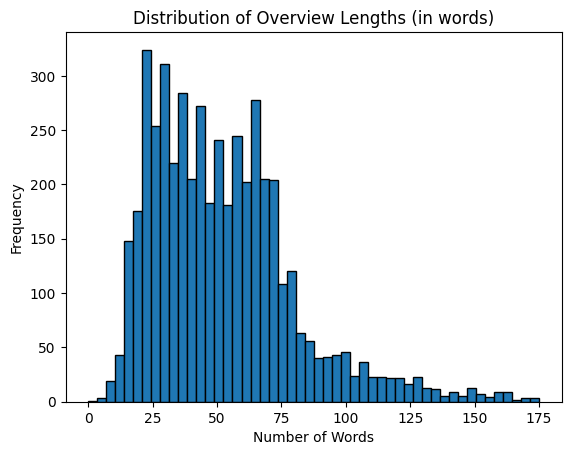

In [ ]:
import re
import matplotlib.pyplot as plt

def remove_punctuation(text):
    """Only retains letters, numbers, underscores, and whitespace"""
    pattern = r'[^\w\s]'
    return re.sub(pattern, '', text)

processed_overviews = []

# loop over df, remove punctuation, make words lowercase, and add it to a new column
for overview in df['overview']:
    processed_overviews.append(remove_punctuation(overview.lower()))

df["proc_overview"] = processed_overviews

# get the word lengths of each overview and store it in a list
overview_lens = [len(overview.split()) for overview in df["proc_overview"]]

# for the sake of simplicity, add these values as a column to the df
df["overview_len"] = overview_lens

# Plot the histogram of overview lengths
plt.hist(overview_lens, bins=50, edgecolor='black')
plt.title("Distribution of Overview Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


**Q2.2.2** What is the shortest overview? What is the longest? In the next step, we need to decide on a standard length of all overviews -- this means dropping overviews less than some value, and truncating longer ones. What length would you choose to minimize the number of movies dropped and maximize the information (words) stored in the overviews?

Shortest overview: 0 words (error?)
Longest overview: 175 words

Looking at the peak of the distribution, the histogram shows the highest frequency of overviews is between 25-70 words.

-> Set a minimum threshold around 25 words to capture most overviews
-> Cut out overviews longer than 75 words

Through this, I can retain most of the existing overview while minimising information loss.

### Q2.2.3
Let's choose overviews of length 15 words. What this means is we need to discard movies that have overviews less than 15 (there are other ways of dealing with it, but this should be fine for now) and truncate the higher ones to the first 15 words.

In [ ]:
token_len = 15  # number of words

# Select rows where overview length is more than or equal to token_len
df = df[df["overview_len"] >= token_len]

# Split each proc_overview into a list of words, select the first token_len words,
# and add the list of words back into df["proc_overview"]
df["proc_overview"] = df["proc_overview"].apply(lambda x: ' '.join(x.split()[:token_len]))

# Print to verify
df

<ipython-input-30-06c99df63b5e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["proc_overview"] = df["proc_overview"].apply(lambda x: ' '.join(x.split()[:token_len]))


,title,overview,genres,proc_genres,one_hot_genres,proc_overview,overview_len
0,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Action,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",in the 22nd century a paraplegic marine is dis...,28
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",Fantasy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",captain barbossa long believed to be dead has ...,34
2,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Action,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",a cryptic message from bonds past sends him on...,41
3,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Thriller,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",following the death of district attorney harve...,65
4,John Carter,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",Adventure,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",john carter is a warweary former military capt...,55
...,...,...,...,...,...,...,...
4794,Cavite,"Adam, a security guard, travels from Californi...","[{""id"": 10769, ""name"": ""Foreign""}, {""id"": 53, ...",Thriller,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",adam a security guard travels from california ...,115
4795,El Mariachi,El Mariachi just wants to play his guitar and ...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Crime,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",el mariachi just wants to play his guitar and ...,62
4797,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...","[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",TV Movie,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",signed sealed delivered introduces a dedicated...,73
4798,Shanghai Calling,When ambitious New York attorney Sam is sent t...,[],Unknown,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",when ambitious new york attorney sam is sent t...,65


### Q2.2.3 Finding the vocabulary length

In order to one-hot encode words, we need to find how many words there are in total, just like in the case of genres. Get all the words, remove duplicates, and sort. Find and print the length of your vocabulary.

In [ ]:
# Get all words from proc_overview, split by spaces, and store them in a set to remove duplicates
all_words = set()
df["proc_overview"].apply(lambda x: all_words.update(x.split()))

# Convert the set to a sorted list
sorted_vocab = sorted(list(all_words))

# Find the length of the vocabulary
vocab_len = len(sorted_vocab)
print(vocab_len)

12493


### Q2.2.4 Encoding the labels

In the case of genres, we one-hot encoded the outputs by taking a single random genre. However, an alternative method is to add up the one-hot encodings to form some kind of histogram. For example, if we have an overview "a brown dog", and our vocab is \[a brown, big, cabbage, dog, goat, cow, turkey\], the one-hot vector would be \[1,1,0,0,1,0,0,0\]. If our overview is "a big brown dog", the one-hot vector would be \[1,1,1,0,1,0,0,0\]. If our overview is "a big big brown dog", the one-hot vector would be \[1,1,2,0,1,0,0,0\]. You can use the `encode_labels` function that you defined earlier.

In [ ]:
# Function to encode words into one-hot vectors based on the vocabulary
def encode_labels(label, unique_labels):
    """ Encodes text labels into a one-hot encoded list """
    out = np.zeros(len(unique_labels))  # Initialize the one-hot vector
    if label in unique_labels:
        out[unique_labels.index(label)] = 1  # Set the corresponding index to 1
    return out

# Initialize list to store encoded labels for each overview
encoded_labels = []

# Loop over each movie overview
for index, row in tqdm(df.iterrows(), total=len(df)):
    sentence_encode = np.zeros(len(sorted_vocab))  # Initialize a zero vector for the sentence
    for word in row["proc_overview"]:  # Loop over each word in the overview
        word_encode = encode_labels(word, sorted_vocab)  # Get the one-hot encoding for the word
        sentence_encode += word_encode  # Sum the encodings for each word
    encoded_labels.append(sentence_encode)  # Store the one-hot encoding for the overview

# Add the one-hot encoded overviews to the DataFrame
df["one_hot_overview"] = encoded_labels

# Print the one-hot encoded overviews to verify
df["one_hot_overview"].head()


100%|██████████| 4707/4707 [01:31<00:00, 51.65it/s]


,one_hot_overview
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


**Q2.2.5** Each vector is a vector of floating point (64-bit) numbers. Assuming each float takes up exactly 16-bytes, how many bytes does this take to store (theoretically)?

In [ ]:
num_movies = df.shape[0]  # number of rows (movies)
print(f'Number of movies: {num_movies}')

# Assuming you have processed the overviews and stored the unique words in a list or set
all_words = [word for overview in df["proc_overview"] for word in overview]
unique_words = sorted(set(all_words))
vocab_len = len(unique_words)
print(f'Vocabulary length: {vocab_len}')


Number of movies: 4707
Vocabulary length: 50


Vocabulary length: 50

Size of each element: 16 bytes (as given).

Number of movies (rows): 4707.

Total bytes = 4707 * 16 * 50 = 3765600
-> 3.77mb

# Q3 Principal Component Analysis

**Q3.1** Using the overview encoded into one-hot encodings, perform PCA and plot this into a 2-D image as a scatter plot.

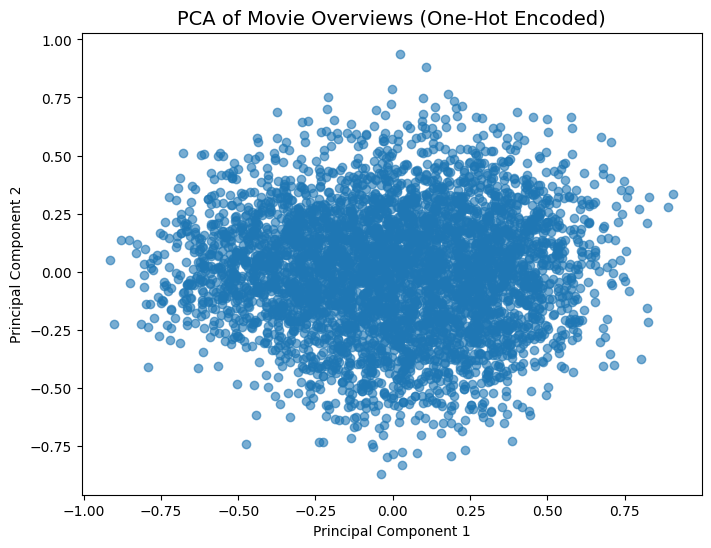

Explained variance ratio by PCA components: [0.15433037 0.10300005]


In [ ]:
# Ensure that the 'one_hot_overview' column contains valid array-like objects (lists or arrays)
import numpy as np
import pandas as pd

# Convert one-hot encodings into a list of lists for PCA input
# Since the one-hot encodings are already lists/arrays, we can directly convert them
one_hot_matrix = df['one_hot_overview'].apply(lambda x: np.array(x) if isinstance(x, str) else x)  # Convert string to array if needed
one_hot_matrix = np.stack(one_hot_matrix)  # Convert list of arrays into a 2D matrix

# Normalize the data (just in case, although for binary encoding, it's not strictly necessary)
one_hot_matrix = one_hot_matrix / np.max(one_hot_matrix, axis=1, keepdims=True)  # Normalize to 0-1

# Set up PCA object (you can adjust n_components based on your preference)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Reduce to 2 components for 2D visualization

# Perform PCA
principal_components = pca.fit_transform(one_hot_matrix)

# Plotting the principal components in a 2D scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.6)
plt.title('PCA of Movie Overviews (One-Hot Encoded)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Optionally: Display the explained variance ratio (to understand how much variance is captured by each component)
print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_}")


There's no clear, obvious clustering or separation, also no distinct groups or subgroups immediatly visible. The data seems to be distributed around the center.

**Q3.3** Quantify how much variance information a 2D PCA projection loses for this dataset.

The 2D PCA projection retains 25.73% (PC1 + PC2) of the original variance.

Thus, the projection loses 74.27% of the variance in the original data.

**Q3.4** Plot a line graph where the y-axis is cumulative explained variance ratio and the x-axis is the number of PCA components.

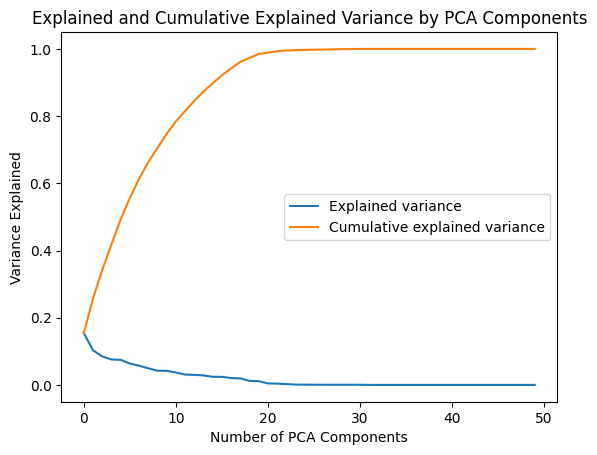

In [ ]:
# Perform PCA with the desired number of components
pca = PCA(n_components=50)  # Set the desired number of components
# Fit and transform the one-hot overview data
x_train_pca = pca.fit_transform(one_hot_matrix)

# Explained variance ratio for each component
powers = pca.explained_variance_ratio_

# Plot explained variance for each component
plt.plot(powers, label="Explained variance")

# Plot cumulative explained variance
cumulative_powers = [np.sum(powers[:i]) for i in range(1, len(powers) + 1)]
plt.plot(cumulative_powers, label="Cumulative explained variance")

# Add labels and legend
plt.xlabel('Number of PCA Components')
plt.ylabel('Variance Explained')
plt.title('Explained and Cumulative Explained Variance by PCA Components')
plt.legend()

# Show the plot
plt.show()

**Q3.5** How many principal components do you need in order to explain 80% of the total variance in the data?

Note: don't just estimate it by eye, write some code to compute it for you.

In [ ]:
#Assuming you have the one-hot matrix (e.g., 'one_hot_matrix') already set up
pca = PCA(n_components=50)  # Set the desired number of components
one_hot_matrix_pca = pca.fit_transform(one_hot_matrix)  # Fit and transform the one-hot encoded data

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 80% of the variance
components_needed = np.argmax(cumulative_variance >= 0.80) + 1  # Adding 1 since index is 0-based

print(f"Number of components needed to explain 80% of the variance: {components_needed}")

Number of components needed to explain 80% of the variance: 12


You need 12 components to explain 80% of the variance.

**Q3.6** Using the number of dimensions you found in Q3.5, fit and transform your overview encodings using PCA and add it to a new column called `overview_pca` in the dataframe.

In [ ]:
n_dims = components_needed

# Initialize the PCA object with the determined number of components
pca = PCA(n_components=n_dims)

# Fit and transform the one-hot encoded overview data (i.e., 'one_hot_matrix')
labels_pca = pca.fit_transform(one_hot_matrix)

# Add the transformed PCA components as a new column in the DataFrame
df["overview_pca"] = list(labels_pca)  # Convert the resulting array to a list for easier storage in the DataFrame

# Check the first few rows of the new 'overview_pca' column to see the PCA components
print(df['overview_pca'].head())

# Check shape of PCA result
print(labels_pca.shape)  # Should show (number_of_samples, n_dims)


0    [0.19767330919653303, -0.3552458341695793, 0.1...
1    [-0.18667611943839885, -0.4161388794630013, -0...
2    [0.22727645376009178, -0.010361356622259675, 0...
3    [0.06644283816635428, 0.3197833672021245, 0.06...
4    [0.2931187130702432, -0.01634466286130857, 0.5...
Name: overview_pca, dtype: object
(4707, 12)


# Q4 K-Means Clustering

**Q4.1** Cluster the movies based on the features that were extracted via PCA in the last step. Set $K=20$. Add the predicted cluster into the dataframe as a new column called `cluster_kmeans`. Print out the elements of cluster number 0 from the dataframe.

In [ ]:
# import KMeans class
from sklearn.cluster import KMeans

# Set the number of clusters (K = 20)
k = 20

# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)  # Set random_state for reproducibility

# Fit the model on the PCA-transformed data
kmeans.fit(df['overview_pca'].tolist())  # Make sure the overview_pca column is a list of arrays

# Get predictions (cluster assignments)
y_preds = kmeans.predict(df['overview_pca'].tolist())

# Add the predicted cluster to the dataframe as a new column
df['cluster_kmeans'] = y_preds

# Print out elements of cluster number 0
cluster_0 = df[df['cluster_kmeans'] == 0]
print(cluster_0)


                                   title  \
24                             King Kong   
72                         Suicide Squad   
77                            Inside Out   
151                              Beowulf   
169   Captain America: The First Avenger   
...                                  ...   
4742         The Brain That Wouldn't Die   
4748                            Gabriela   
4751                       The Naked Ape   
4769                        Down Terrace   
4783                    Breaking Upwards   

                                               overview  \
24    In 1933 New York, an overly ambitious movie pr...   
72    From DC Comics comes the Suicide Squad, an ant...   
77    Growing up can be a bumpy road, and it's no ex...   
151   6th-century Scandinavian warrior, Beowulf emba...   
169   Predominantly set during World War II, Steve R...   
...                                                 ...   
4742  Dr. Bill Cortner (Jason Evers) and his fiancée...   

**Q4.2** Does this clustering seem alright to you (based on your movie watching history)? Are there movies that go well together and movies that don't?

Intuitively, this seems to makes sense. E.g. Suicide Squad, King Kong and Captain America are all action movies. They seem to have been clustered by the genres of Action, Adventure,...

There is still some subtle genre indifferencs, that PCA did not fully grasp (with the current number of 12 components).

**Q4.3** Now, we'll figure out whether using the elbow method is right for this dataset. Plot a loss (using `kmeans.inertia_`) versus cluster size plot. Is there an elbow that you see clearly? What cluster size would you choose?

The inertia starts very high at 1-2 clusters (around 2400).
There's a sharp, steep decline in inertia from 1 to about 5-6 clusters.
After 8-10 clusters, the curve begins to flatten significantly.

The most prominent elbow appears around 8-9 clusters. At this point:
- The rate of inertia reduction slows dramatically.
- You capture most of the meaningful structure in the data.
- Adding more clusters provides minimal additional (marginal) information.

I would recommend choosing 9 clusters because:

It sits at the most noticeable inflection point of the curve, thus balancing model complexity with information capture.
Beyond this point, you're essentially overfitting the data with additional clusters that don't provide substantial new insights.

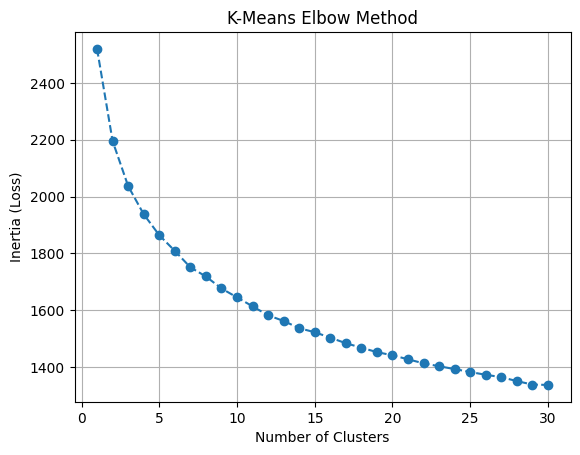

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# List to store inertia values
inertia_values = []

# Test for a range of cluster sizes (e.g., from 1 to 30 clusters)
cluster_range = range(1, 31)

# Loop over different cluster sizes
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df["overview_pca"].tolist())  # Fit using the PCA features
    inertia_values.append(kmeans.inertia_)  # Store inertia (loss)

# Plotting the loss (inertia) versus cluster size
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
plt.title("K-Means Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (Loss)")
plt.grid(True)
plt.show()

# Q5 Gaussian Mixture Models

**Q5.1** As with the K-means above, cluster the movies based on the features that were extracted via PCA in a previous step. Set $K=20$. Add the predicted cluster into the dataframe as a new column called `cluster_gmm`. Print out the elements of a single cluster of your choice from the dataframe.

In [ ]:
from sklearn.mixture import GaussianMixture

# Set the number of clusters (K) to 20
k = 20

# Fit a Gaussian Mixture Model with 20 components
gmm = GaussianMixture(n_components=k, random_state=42)
gmm.fit(df["overview_pca"].tolist())  # Fit the model on the PCA features

# Predict the clusters for each movie
y_gmm_preds = gmm.predict(df["overview_pca"].tolist())

# Add the predicted clusters as a new column in the DataFrame
df["cluster_gmm"] = y_gmm_preds

# Print out elements of a single cluster (e.g., cluster number 0)
cluster_number = 0
cluster_elements = df[df["cluster_gmm"] == cluster_number]

# Display the movies in cluster 0
print(cluster_elements[["title", "overview", "cluster_gmm"]])


                                                  title  \
24                                            King Kong   
72                                        Suicide Squad   
366                                          Hollow Man   
375                                    Bicentennial Man   
377                                     The Devil's Own   
...                                                 ...   
4171  Dr. Strangelove or: How I Learned to Stop Worr...   
4241                               Forty Shades of Blue   
4311                                         Below Zero   
4408                                   The Party's Over   
4569                                       Metropolitan   

                                               overview  cluster_gmm  
24    In 1933 New York, an overly ambitious movie pr...            0  
72    From DC Comics comes the Suicide Squad, an ant...            0  
366   Cocky researcher, Sebastian Caine is working o...            0  
375   R

**Q4.2** Does this clustering seem alright to you (based on your movie watching history)? Are there movies that go well together and movies that don't? How does this compare to K-Means Clustering?

After analyzing the GMM clustering, the cluster composition appears somewhat random, with movies spanning diverse genres and eras (e.g., King Kong, Dr. Strangelove, Forty Shades of Blue). This suggests the current clustering method might not be effectively capturing semantic similarities and differences between movie overviews.
Compared to K-Means, GMM offer more probabilistic cluster assignments and can create overlapping, non-spherical clusters.

The clustering appears to be using insufficiently distinctive features.

**Q4.3** Let's check out the size of the clusters. Create a double bar plot (**as you did in the last assignment**) showing the different sizes of the clusters.

*Hint: you may want to consider `df.value_counts()` if you're unfamiliar.*

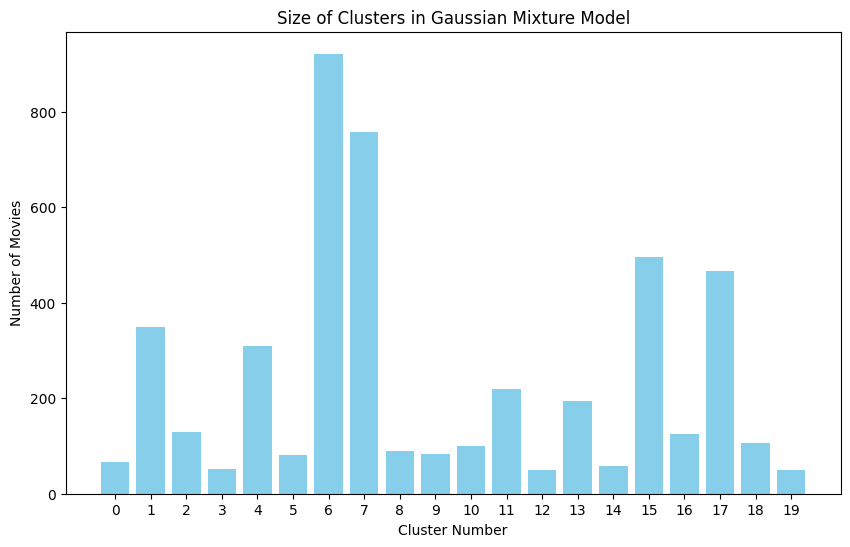

In [ ]:
import matplotlib.pyplot as plt

# Get the count of movies in each cluster
cluster_sizes = df["cluster_gmm"].value_counts()

# Create the bar plot for cluster sizes
plt.figure(figsize=(10, 6))
plt.bar(cluster_sizes.index, cluster_sizes.values, color='skyblue')

# Add labels, title, and legend
plt.xlabel('Cluster Number')
plt.ylabel('Number of Movies')
plt.title('Size of Clusters in Gaussian Mixture Model')
plt.xticks(cluster_sizes.index)  # Make sure the x-ticks match the cluster numbers
plt.show()

**Q4.4** Do you see a significant difference in the sizes of the clusters? Which is more uniform? Any thought on why?

There are significant differences in cluster sizes.

Cluster 6 and 7 are the largest, containing around 800-850 movies.
Clusters 1,4,15 and 17 are also substantial, with 300-500 movies.
The other clusters are quite small, with fewer than 100 movies.

The distribution is highly non-uniform, as large differences in cluster size exist.

Potential Reasons:
- Uneven distribution of movie overview characteristics (e.g. much more action movies than dramas)
- Oversensitivity of the model to certain feature dimensions

# Q6: A very simple recommender system

One useful thing that clustering is often used for (though at a much greater complexity) is in **recommender systems**. These are systems with users and items (movies, files, documents, etc.), where new items are shown to the user based on what they've previously interacted with, and possibly also on the behaviour of other users.

**Q6.1** Assume your dentist has just watched the movie Avatar and asks you for a recommendation. Lucky for you, you just finished this assignment. Using the cluster indices of the movie Avatar for both the K-means and GMM methods, print out suggestions for new movies.

In [ ]:
# Assuming "Avatar" is in the dataset and df contains the cluster labels

prev_watch = "Avatar"

# Find the index of the movie "Avatar"
avatar_index = df[df['title'] == prev_watch].index[0]

# Find the cluster index for "Avatar" using K-Means and GMM
cluster_kmeans = df.loc[avatar_index, 'cluster_kmeans']
cluster_gmm = df.loc[avatar_index, 'cluster_gmm']

# Get movie suggestions based on K-Means cluster
recommended_kmeans = df[df['cluster_kmeans'] == cluster_kmeans]['title'].tolist()

# Get movie suggestions based on GMM cluster
recommended_gmm = df[df['cluster_gmm'] == cluster_gmm]['title'].tolist()

# Print out recommendations for K-Means and GMM
print(f"Movies recommended based on K-Means clustering (cluster {cluster_kmeans}):")
print([movie for movie in recommended_kmeans if movie != prev_watch])

print(f"\nMovies recommended based on GMM clustering (cluster {cluster_gmm}):")
print([movie for movie in recommended_gmm if movie != prev_watch])


Movies recommended based on K-Means clustering (cluster 10):
['Skyfall', 'Alice in Wonderland', 'X-Men: The Last Stand', 'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe', 'The Polar Express', 'Terminator 3: Rise of the Machines', 'Frozen', 'G-Force', 'Dark Shadows', 'Die Another Day', 'Men in Black II', 'The World Is Not Enough', 'Prometheus', 'Windtalkers', "Ocean's Twelve", 'Live Free or Die Hard', 'The Martian', 'Black Hawk Down', 'The Road to El Dorado', 'The Lord of the Rings: The Return of the King', 'Jurassic Park III', 'Bicentennial Man', 'Cast Away', 'The Three Musketeers', 'The Holiday', 'The Hunger Games', 'Batman Returns', 'The Haunting', 'Independence Day', 'Hairspray', 'Hotel for Dogs', 'Hollywood Homicide', 'Unbreakable', 'Shrek 2', 'xXx', 'War Horse', 'The Dilemma', 'Bad Company', 'The Twilight Saga: Eclipse', 'Ted 2', 'Step Brothers', 'Death Race', 'The Green Mile', 'The Bourne Identity', 'Eat Pray Love', 'The Tale of Despereaux', 'Under Siege 2: Dark T

**Q6.2** Are any of the two recommender systems any good? Would you use them if your real dentist asks for a movie suggestion?

K-Means Recommendations (Cluster 10):
Suggestions include movies like "Skyfall," "The Polar Express," and "Jurassic Park III." While they share some action and adventure themes, the cluster is too diverse, including family-friendly movies like Shrek 2 and comedies, which may not align with Avatar's tone.

GMM Recommendations (Cluster 7):
Suggestions include "John Carter," "Pirates of the Caribbean," and "Man of Steel." These are much more consistent with Avatar's action, adventure, and sci-fi elements, making them a better fit.

Conclusion:
The GMM system provides more relevant recommendations based on Avatar's genre, making it the better choice for a movie suggestion. The K-Means system is too broad and may offer less targeted, more random suggestions.

**Q6.3** How would you try making the recommender systems better?

- Refine Clustering: Include more detailed features (e.g.actors, directors) to improve cluster relevance and movie matching.

- Hybrid Approach: Combine content-based and collaborative filtering methods for a more balanced and accurate recommendation system.

- Deep Learning: Use neural networks to capture complex relationships between users and movies.

**Q6.4** Say your dentist likes the movies you suggested and has watched a few more since you met him last. How would you incorporate this fact (recommendation based on multiple movies) into your suggestions?

1. Aggregate Features: Calculate the average features of the movies your dentist has watched to identify broader preferences.
2. Cluster Similar Movies: Recommend films within the same cluster as the movies your dentist has watched recently.
3. Content-Based Filtering: Track keywords or themes from the watched movies to suggest similar ones.
4. Collaborative Filtering: Use behavior from similar users to recommend movies they liked.

**Q6.5** An alternative method for recommendations is to use your encoded movie-feature vectors (in this case your overview+PCA vector) in order to find out what movie may be most similar to the current one. In the case of K-Means and GMMs, "similarity" referred to Euclidean distance. However, in this exercise, we will use *cosine similarity*, which is another very common similarity measure, and is related to the angle between two vectors. It is defined as:

$$sim(v_1, v_2)=\frac{v_1\cdot v_2}{||v_1||\cdot||v_2||}$$

Where $v_1$ and $v_2$ are vectors and the operator $||\cdot||$ is the norm of the vector. The function ranges from $[-1,1]$ (where 1 means that the vectors point in the same direction).

Define an appropriate function `cosine_sim`. Add a column called `cos_sim_to_avatar` in the df and print out the head of the df, sorted by the similarity. What movies would you recommend now? Is this better than the clustering methods?

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# If the PCA vectors aren't added yet:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['overview'])
pca = PCA(n_components=50)  # You can adjust the number of components
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())
df['pca_vector'] = list(pca_matrix)

# Define cosine similarity function
def cosine_sim(v1, v2):
    return cosine_similarity([v1], [v2])[0][0]

# Get overview_pca encoding of previously watched film ("Avatar" in this case)
prev_watch_enc = df[df['title'] == 'Avatar']['pca_vector'].values[0]

# Set up place to store similarities
sims = []

# Loop through each row in the dataframe and compute cosine similarity
for i, row in df.iterrows():
    sims.append(cosine_sim(row['pca_vector'], prev_watch_enc))

# Add the cosine similarities to the dataframe
df["cos_sim_to_avatar"] = sims

# Sort the dataframe by cosine similarity (highest similarity first)
df = df.sort_values(by="cos_sim_to_avatar", ascending=False)

# Print the dataframe to verify
df[['title', 'cos_sim_to_avatar']].head()

,title,cos_sim_to_avatar
0,Avatar,1.000000
1272,Impostor,0.756417
972,The Host,0.753082
151,Beowulf,0.742620
461,Lost in Space,0.740351


I would recommen Impostor, The Host, Beowulf and Lost in Space, as they have the highest cosine similarity.  It is a more precise choice, if the goal is to recommend more similar movies to the initial.

# Q7 Unsupervised Learning as a Tool

At the end of this brief forey into natural language processing, we will end with an interesting task: can a machine predict the genre of a movie based purely on the first 10 words of its overview?

First, the following cell shuffles the dataset and splits it into a training and test set. The random seed and random state ensure that the train and test samples are the same for you all the time, and *probably* your classmates too. You can verify this by printing out the dataframes and checking it for yourself.

In [ ]:
np.random.seed(0)
n_train = int(0.8*len(df))
df_shuffle = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_shuffle[:n_train].reset_index(drop=True)
df_test = df_shuffle[n_train:].reset_index(drop=True)
print(len(df_train), len(df_test))

3765 942


## Train, test, evaluate

Using a supervised learning method of your choice, try predicting the genre of a movie from the overview. The way you preprocess your data is up to you, and you can take inspiration from the above exercises (e.g. PCA on the one-hot encodings as input, one-hot label encodings as output). There are a number of hyperparameters you can choose depending on your selected method (number of words in your overview, number of dimensions, number of clusters, hyperparameters of your supervised model...), thus, make sure to perform hyperparameter optimization in some way (grid-search, fine-tuning, etc). Once you are happy with how your model is performing, **print out the train_score (accuracy$\in[0,1]$), test_score (accuracy$\in[0,1]$), mean training time (in seconds), and mean inference time (in seconds) of your model**.

If you are already excited about neural networks, you may also choose to use that as your supervised method. The easiest way to do it is with sklearn's `MLPClassifier` module. The main hyperparameter you would need to tune is the architecture of your model -- how many hidden layers, and how large is each one. For this task, in order to get best performance, you do not necessarily need an MLP (multi-layer perceptron) but feel free to experiment.

*Hint: the `train_and_eval` function from the last assignment should be of great help here*

In [ ]:
print(df_train.columns)
print(df_test.columns)

Index(['title', 'overview', 'genres', 'proc_genres', 'one_hot_genres',
       'proc_overview', 'overview_len', 'one_hot_overview', 'overview_pca',
       'cluster_kmeans', 'cluster_gmm', 'pca_vector', 'cos_sim_to_avatar',
       'overview_10_words'],
      dtype='object')
Index(['title', 'overview', 'genres', 'proc_genres', 'one_hot_genres',
       'proc_overview', 'overview_len', 'one_hot_overview', 'overview_pca',
       'cluster_kmeans', 'cluster_gmm', 'pca_vector', 'cos_sim_to_avatar',
       'overview_10_words'],
      dtype='object')


In [ ]:
#LogicalRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from time import time

# Ensure that 'genres' is a list by parsing the string representation of lists (if needed)
df['genres'] = df['genres'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Extract the first genre for classification (if available)
df['genre'] = df['genres'].apply(lambda x: x[0]['name'] if isinstance(x, list) and len(x) > 0 else None)

# Remove rows where 'genre' is None (if there are any)
df = df.dropna(subset=['genre'])

# Extract the first 10 words of the overview
df['overview_first_10_words'] = df['overview'].apply(lambda x: ' '.join(x.split()[:10]))

# Split the dataset into train and test sets
np.random.seed(0)
n_train = int(0.8 * len(df))
df_shuffle = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_shuffle[:n_train].reset_index(drop=True)
df_test = df_shuffle[n_train:].reset_index(drop=True)

# Separate features and target
X_train = df_train['overview_first_10_words']
y_train = df_train['genre']
X_test = df_test['overview_first_10_words']
y_test = df_test['genre']

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # You can tweak the number of features

# One-Hot Encoding of the target genres
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Now we will use Logistic Regression as our supervised method
# We will also perform grid search for hyperparameter tuning
param_grid = {
    'logisticregression__C': [0.1, 1, 10],  # Regularization parameter
    'logisticregression__max_iter': [100, 200],
}

# Create a pipeline with TF-IDF vectorizer and Logistic Regression
pipe = make_pipeline(
    TfidfVectorizer(max_features=1000),
    LogisticRegression(solver='liblinear', multi_class='ovr')
)

# Grid Search for Hyperparameter Tuning
grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)

# Measure training time
start_time = time()
grid_search.fit(X_train, y_train)
end_time = time()

# Training time
training_time = end_time - start_time

# Best model after grid search
best_model = grid_search.best_estimator_

# Evaluate on training and test data
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

# Measure inference time
start_time = time()
y_pred = best_model.predict(X_test)
end_time = time()
inference_time = end_time - start_time

# Accuracy score
test_accuracy = accuracy_score(y_test, y_pred)

# Print results
print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print("Mean training time (in seconds):", training_time)
print("Mean inference time (in seconds):", inference_time)
print("Test accuracy (via accuracy_score):", test_accuracy)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


<ipython-input-69-a11beb63ee35>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overview_first_10_words'] = df['overview'].apply(lambda x: ' '.join(x.split()[:10]))
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Train accuracy: 0.4664886515353805
Test accuracy: 0.31696905016008536
Mean training time (in seconds): 12.940785646438599
Mean inference time (in seconds): 0.021170854568481445
Test accuracy (via accuracy_score): 0.31696905016008536


Write a paragraph of ~150 words about how you went about selecting and tuning your model, and how you may want to make improvements to your model if you were to continue working on this. Plots are very good but not strictly necessary (i.e. try to add plots if you can).

To select and execute my model, I did both Logical Regression and Random Forest. I started with Log Reg due to its simplicity and easiness to interpret. I used cross-validation to optimise hyperparameters using grid search, which improved the model's performance.

Then, I did a Random Forest Model, to compare it to the Log Reg. The Ran For Model had a higher accuracies for both test and train. Both models showed similar test accuracy (ca 0.32), but Ran For had a signicifantly higher train accuracy (0.66 vs 0.47). This indicates, that the Random Forest Model was likely overfitting the training data, therefore while being better to memorise the training data, it was not really better at generalising this.

For further improvements, it would be good to further fine tune the hyperparameters (especially for Ran For), to balance the trade-off of over and underfitting. Depending on the size of the data, a neural network could also yield a higher performance while being much more complex.

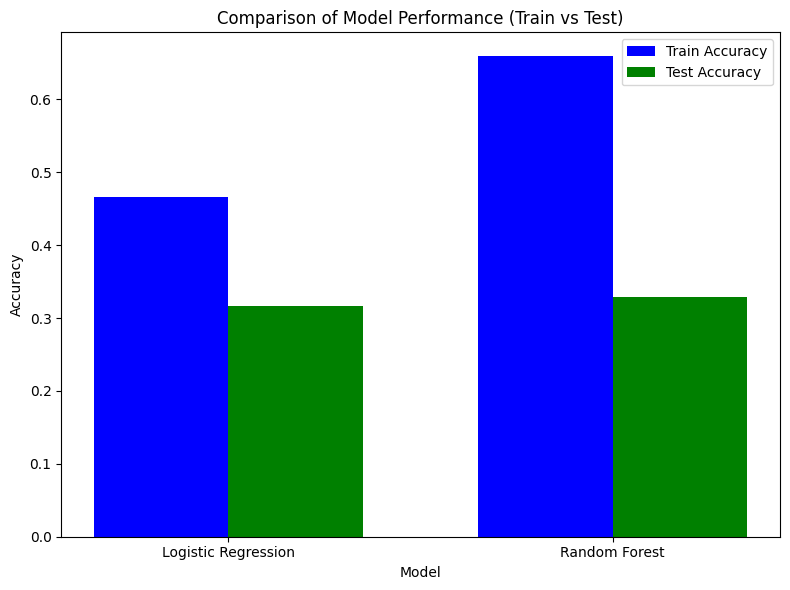

In [ ]:
import matplotlib.pyplot as plt

# Define the models' accuracies
models = ['Logistic Regression', 'Random Forest']

log_reg_train_accuracy = 0.466
log_reg_test_accuracy = 0.317

rf_train_accuracy = 0.659
rf_test_accuracy = 0.329

train_accuracies = [log_reg_train_accuracy, rf_train_accuracy]
test_accuracies = [log_reg_test_accuracy, rf_test_accuracy]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
index = range(len(models))

# Plot bars for train and test accuracies
bar1 = ax.bar(index, train_accuracies, bar_width, label='Train Accuracy', color='b')
bar2 = ax.bar([i + bar_width for i in index], test_accuracies, bar_width, label='Test Accuracy', color='g')

# Labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Model Performance (Train vs Test)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
#Rndm Forest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import time

# Assuming 'df' is the DataFrame with the required columns
# Step 1: Preprocess data - Extract first 10 words from 'overview'
df['overview_first_10_words'] = df['overview'].apply(lambda x: ' '.join(x.split()[:10]))

# Step 2: Prepare features (X) and target (y)
X = df['overview_first_10_words']
y = df['genre']  # Assuming 'genre' column contains the genre of the movie

# Step 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 5: Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Step 6: Hyperparameter tuning using GridSearchCV (optional but can improve performance)
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, None],      # Maximum depth of trees
    'min_samples_split': [2, 5],      # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

# Step 7: Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_tfidf, y_train)

# Step 8: Best hyperparameters from grid search
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Step 9: Train Random Forest with the best hyperparameters
rf_best = grid_search.best_estimator_

# Step 10: Model evaluation
start_time = time.time()
y_train_pred = rf_best.predict(X_train_tfidf)
train_time = time.time() - start_time

start_time = time.time()
y_test_pred = rf_best.predict(X_test_tfidf)
inference_time = time.time() - start_time

# Accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")
print(f"Mean training time (in seconds): {train_time}")
print(f"Mean inference time (in seconds): {inference_time}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Train accuracy: 0.6598130841121496
Test accuracy: 0.3287086446104589
Mean training time (in seconds): 0.2739253044128418
Mean inference time (in seconds): 0.0793004035949707


# BONUS

If you are happy with your score and wish to see how well it is doing with respect to other people (a sort of mini-competition), fill out the following form with the train_score (accuracy$\in[0,1]$), test_score (accuracy$\in[0,1]$), mean training time (in seconds), and mean inference time (in seconds) of your model, as well as what method you use. You can submit as many times before the deadline as you wish. Your final results will be correlated with your submission in order to validate your results (if we cannot validate them, they will be immediately disqualified).

[FORM HERE](https://forms.gle/rXRtXScABH5oDLRWA)